In [6]:
import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import numpy as np
import pandas as pd
import xgboost as xgb
import signal
import seaborn as sns
import optuna

**Считываем файл**

In [2]:
df_yn = pd.read_excel("C:\универ\Диплом\ун 90-10.xlsx")
X = df_yn[['х1', 'х2', 'х3', 'х4', 'х5', 'х6', 'х7', 'х8', 'х9', 'х10']]
y = df_yn['Yн']

In [64]:
df_yc = pd.read_excel("C:\универ\Диплом\ус 90-10.xlsx")
X = df_yc[['х1', 'х2', 'х3', 'х4', 'х5', 'х6', 'х7', 'х8', 'х9', 'х10']]
y = df_yc['Yс']

In [3]:
df_yv = pd.read_excel("C:\универ\Диплом\ув 90-10.xlsx")
X = df_yv[['х1', 'х2', 'х3', 'х4', 'х5', 'х6', 'х7', 'х8', 'х9', 'х10']]
y = df_yv['Ув']

In [4]:
X.head(2)

,х1,х2,х3,х4,х5,х6,х7,х8,х9,х10
0,9.4,10.5,4.15,91.631206,8.0,9.9,228,31.0,0.8,51.334268
1,9.4,11.0,4.20,88.652482,2.0,9.9,565,31.0,1.2,47.393132


In [61]:
y.head(2)

0    27
1    26
Name: Yс, dtype: int64

param_dist = {
    'n_estimators': np.arange(30, 200, 10),  # от 30 до 200 
    'learning_rate': np.arange(0.1, 0.5, 0.1),  # от 0.01 до 0.3
    'max_depth': np.arange(3, 15, 1), # от 3 до 15
    'subsample':np.arange(0.5, 1, 0.1), # от 0.5 до 1 
    'colsample_bytree': np.arange(0.3, 1, 0.1),  # от  0.3 до 1
    'min_child_weight': np.arange(1, 10, 1), # от 1 до 10
    'gamma': np.arange(0, 5, 1),  # от 0 до 5
    'reg_lambda': np.arange(0, 10, 1),  # от 0 до 10
    'reg_alpha': np.arange(0, 5, 1), # от 0 до 5
    'tree_method': ['auto', 'exact', 'approx', 'hist'],}

**Bayesian Optimization**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

def objective(trial):
    params = {
    'n_estimators': trial.suggest_int('n_estimators', 40, 100, step=10),  # немного деревьев
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05, step=0.01),  # очень осторожное обучение
    'max_depth': trial.suggest_int('max_depth', 1, 6, step=1),  # неглубокие деревья
    'subsample': trial.suggest_float('subsample', 0.4, 0.7, step=0.1),  # меньше данных на дерево
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.6, step=0.1),  # меньше признаков
    'min_child_weight': trial.suggest_int('min_child_weight', 5, 10, step=1),  # больше "веса" узла = меньше переобучение
    'gamma': trial.suggest_int('gamma', 3, 6, step=1),  # штраф за разбиение
    'reg_lambda': trial.suggest_float('reg_lambda', 2.0, 5.0, step=0.5),  # L2-регуляризация
    'reg_alpha': trial.suggest_float('reg_alpha', 1.0, 3.0, step=0.5),  # L1-регуляризация
    'tree_method': 'exact',
    'objective': 'reg:squarederror',
    'random_state': 15,
    'n_jobs': -1}
    
    model = xgb.XGBRegressor(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean()
    return score

# Запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

best_params = study.best_params
print(f'Лучшие параметры: {best_params}')

best_model = xgb.XGBRegressor(
    **best_params,
    objective='reg:squarederror',
    tree_method='exact',
    random_state=15,
    n_jobs=-1)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Среднеквадратичная ошибка (MSE) на тесте: {mse:.4f}')
rmse = np.sqrt(mse)
print(f'Корень из среднеквадратичной ошибки (RMSE): {rmse:.4f}')
y_test_safe = y_test.replace(0, np.nan).dropna()
mape = np.mean(np.abs((y_test_safe - y_pred[:len(y_test_safe)]) / y_test_safe)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

cross_val_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_score = np.mean(cross_val_scores)
print(f'Средняя ошибка по кросс-валидации: {-mean_cv_score:.4f}')

predictions_df = pd.DataFrame({'Фактическое значение': y_test.values, 'Предсказанное значение': y_pred})
display(predictions_df)

[I 2025-04-22 22:55:13,797] A new study created in memory with name: no-name-e1387307-63ff-4615-93cc-80626c0bc1fb


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-04-22 22:55:14,000] Trial 0 finished with value: -6.7725079773113945 and parameters: {'n_estimators': 50, 'learning_rate': 0.05, 'max_depth': 2, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 10, 'gamma': 3, 'reg_lambda': 5.0, 'reg_alpha': 3.0}. Best is trial 0 with value: -6.7725079773113945.
[I 2025-04-22 22:55:14,148] Trial 1 finished with value: -6.931292773965106 and parameters: {'n_estimators': 70, 'learning_rate': 0.02, 'max_depth': 4, 'subsample': 0.4, 'colsample_bytree': 0.6, 'min_child_weight': 9, 'gamma': 3, 'reg_lambda': 2.5, 'reg_alpha': 2.0}. Best is trial 0 with value: -6.7725079773113945.
[I 2025-04-22 22:55:14,304] Trial 2 finished with value: -6.47751663446603 and parameters: {'n_estimators': 90, 'learning_rate': 0.04, 'max_depth': 6, 'subsample': 0.4, 'colsample_bytree': 0.5, 'min_child_weight': 8, 'gamma': 5, 'reg_lambda': 5.0, 'reg_alpha': 3.0}. Best is trial 2 with value: -6.47751663446603.
[I 2025-04-22 22:55:14,413] Trial 3 finished with 

,Фактическое значение,Предсказанное значение
0,22,24.647097
1,28,25.323385
2,26,23.682663
3,22,22.228806
4,24,24.768255
5,19,21.913059
6,25,25.696766
7,18,21.606928
8,26,24.184168
9,24,24.494635


**Метрики качества**

In [68]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train.replace(0, np.nan).dropna())) * 100

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mape = np.mean(np.abs((y_test - y_test_pred[:len(y_test)]) / y_test.replace(0, np.nan).dropna())) * 100

cv_results = cross_validate(best_model, X_train, y_train, cv=5, 
                            scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'])

cv_mse = -cv_results['test_neg_mean_squared_error'].mean()  # Преобразуем в положительное значение
cv_mae = -cv_results['test_neg_mean_absolute_error'].mean()  # Преобразуем в положительное значение
cv_r2 = cv_results['test_r2'].mean()

# Таблица метрик
metrics_df = pd.DataFrame({
    'Метрика': ['MSE', 'MAE', 'R²', 'MAPE (%)'],
    'Обучающая выборка': [train_mse, train_mae, train_r2, train_mape],
    'Тестовая выборка': [test_mse, test_mae, test_r2, test_mape],
    'Кросс-валидация': [cv_mse, cv_mae, cv_r2, '-']  # Для MAPE по кросс-валидации трудно использовать, т.к. это метрика для целевой переменной, которой может не быть в данных
})

display(metrics_df.round(3))


,Метрика,Обучающая выборка,Тестовая выборка,Кросс-валидация
0,MSE,3.597,3.880,5.960721
1,MAE,1.577,1.556,2.024498
2,R²,0.514,0.432,0.163078
3,MAPE (%),6.574,6.755,-


**модель RandomizedSearchCV**

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

param_dist = {
    'n_estimators': np.arange(35, 65, 5),  # Лучше не больше 100-150 
    'learning_rate': np.arange(0.1, 0.3, 0.1),  # от 0.01 до 0.3
    'max_depth': np.arange(2, 5, 1), # 3–6 — разумно, 7+ уже рискованно
    'subsample':np.arange(0.4, 0.7, 0.1), # от 0.5 до 1   уменьшение доли выборки, используемой для каждого дерева, помогает предотвратить переобучение
    'colsample_bytree': np.arange(0.3, 0.6, 0.1),  # от 0.5 до 0.8   уменьшая количество признаков, используемых для построения каждого дерева, можно уменьшить переобучение
    'min_child_weight': np.arange(1, 10, 1), # от 1 до 10 ; 3-10
    'gamma': np.arange(3, 7, 1),  # от 0 до 5  Чем выше gamma, тем меньше склонность к переобучению
    'reg_lambda': np.arange(5, 10, 1),  # от 0 до 10  L2-регуляризации и помогает уменьшить склонность к переобучению
    'reg_alpha': np.arange(3, 7, 1), # от 0 до 5 помогает уменьшить сложность модели и отбирать более важные признаки.
    'tree_method': ['exact']}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', tree_method='auto')
random_search = RandomizedSearchCV(
    estimator=xgb_model, 
    param_distributions=param_dist, 
    n_iter=500,  
    cv=5, 
    scoring='neg_mean_squared_error', 
    verbose=2, 
    random_state=15)

random_search.fit(X_train, y_train)
best_params = random_search.best_params_
print(f'Лучшие параметры: {best_params}')
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Среднеквадратичная ошибка (MSE) на тесте: {mse:.4f}')

y_test_safe = y_test.replace(0, np.nan).dropna()
mape = np.mean(np.abs((y_test_safe - y_pred[:len(y_test_safe)]) / y_test_safe)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

cross_val_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_score = np.mean(cross_val_scores)
print(f'Средняя ошибка по кросс-валидации: {-mean_cv_score:.4f}')

predictions_df = pd.DataFrame({'Фактическое значение': y_test.values, 'Предсказанное значение': y_pred})
display(predictions_df)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] END colsample_bytree=0.3, gamma=3, learning_rate=0.1, max_depth=4, min_child_weight=4, n_estimators=40, reg_alpha=3, reg_lambda=6, subsample=0.5, tree_method=exact; total time=   0.0s
[CV] END colsample_bytree=0.3, gamma=3, learning_rate=0.1, max_depth=4, min_child_weight=4, n_estimators=40, reg_alpha=3, reg_lambda=6, subsample=0.5, tree_method=exact; total time=   0.0s
[CV] END colsample_bytree=0.3, gamma=3, learning_rate=0.1, max_depth=4, min_child_weight=4, n_estimators=40, reg_alpha=3, reg_lambda=6, subsample=0.5, tree_method=exact; total time=   0.0s
[CV] END colsample_bytree=0.3, gamma=3, learning_rate=0.1, max_depth=4, min_child_weight=4, n_estimators=40, reg_alpha=3, reg_lambda=6, subsample=0.5, tree_method=exact; total time=   0.0s
[CV] END colsample_bytree=0.3, gamma=3, learning_rate=0.1, max_depth=4, min_child_weight=4, n_estimators=40, reg_alpha=3, reg_lambda=6, subsample=0.5, tree_method=exact; total time

,Фактическое значение,Предсказанное значение
0,21,27.404875
1,30,29.073288
2,28,24.768063
3,23,27.147360
4,28,29.305449
5,18,25.884966
6,23,27.788179
7,19,23.445635
8,32,27.584597
9,24,24.239555


**График ошибок по фолдам кросс-валидации (MSE)**

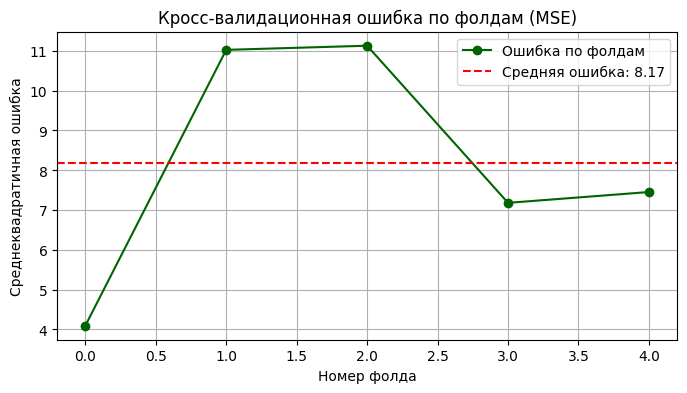

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(-cross_val_scores, marker='o', linestyle='-', color='darkgreen', label='Ошибка по фолдам')
plt.axhline(-mean_cv_score, color='red', linestyle='--', label=f'Средняя ошибка: {-mean_cv_score:.2f}')
plt.title('Кросс-валидационная ошибка по фолдам (MSE)')
plt.xlabel('Номер фолда')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend()
plt.grid(True)
plt.show()


**Boxplot для сравнения MSE по фолдам**

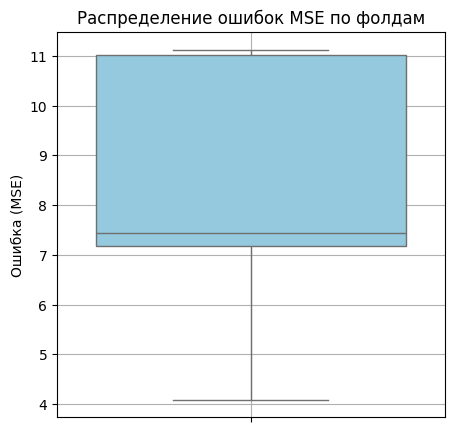

In [15]:
plt.figure(figsize=(5, 5))
sns.boxplot(y=-cross_val_scores, color='skyblue')
plt.title('Распределение ошибок MSE по фолдам')
plt.ylabel('Ошибка (MSE)')
plt.grid(True)
plt.show()


**Дополнительно: сравнение ошибок Train / Test / CV**

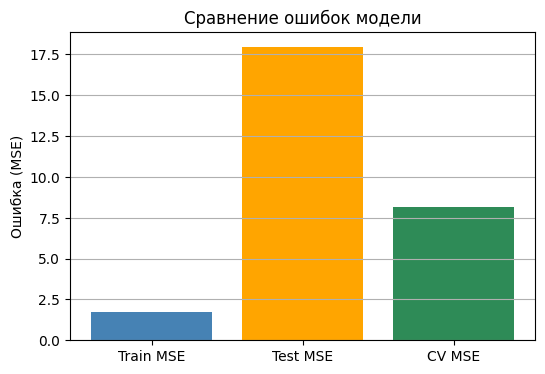

In [17]:
errors = {
    'Train MSE': train_mse,
    'Test MSE': test_mse,
    'CV MSE': -mean_cv_score}

plt.figure(figsize=(6, 4))
plt.bar(errors.keys(), errors.values(), color=['steelblue', 'orange', 'seagreen'])
plt.title('Сравнение ошибок модели')
plt.ylabel('Ошибка (MSE)')
plt.grid(axis='y')
plt.show()


**модель GridSearchCV**

In [20]:
param_dist = {
    'n_estimators': np.arange(49, 52, 1),  # от 30 до 200 
    'learning_rate': np.arange(0.3, 0.5, 0.1),  # от 0.01 до 0.3
    'max_depth': np.arange(8, 10, 1), # от 3 до 15
    'subsample': np.arange(0.7, 0.8, 0.1), # от 0.5 до 1 
    'colsample_bytree': np.arange(0.6, 0.8, 0.1),  # от  0.3 до 1
    'min_child_weight': np.arange(1, 3, 1), # от 1 до 10
    'gamma': np.arange(2, 4, 1),  # от 0 до 5
    'reg_lambda': np.arange(4, 6, 1),  # от 0 до 10
    'reg_alpha': np.arange(2, 4, 1), # от 0 до 5
    'tree_method': ['approx'],
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', tree_method='auto')
grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_dist, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    verbose=2)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f'Лучшие параметры: {best_params}')
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Среднеквадратичная ошибка (MSE) на тесте: {mse:.4f}')

y_test_safe = y_test.replace(0, np.nan).dropna()
mape = np.mean(np.abs((y_test_safe - y_pred[:len(y_test_safe)]) / y_test_safe)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

cross_val_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mean_cv_score = np.mean(cross_val_scores)
print(f'Средняя ошибка по кросс-валидации: {-mean_cv_score:.4f}')

predictions_df = pd.DataFrame({'Фактическое значение': y_test.values, 'Предсказанное значение': y_pred})
display(predictions_df)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
[CV] END colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=49, reg_alpha=2, reg_lambda=4, subsample=0.7, tree_method=approx; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=49, reg_alpha=2, reg_lambda=4, subsample=0.7, tree_method=approx; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=49, reg_alpha=2, reg_lambda=4, subsample=0.7, tree_method=approx; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=49, reg_alpha=2, reg_lambda=4, subsample=0.7, tree_method=approx; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=2, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=49, reg_alpha=2, reg_lambda=4, subsample=0.7, tree_method=approx; tota

,Фактическое значение,Предсказанное значение
0,22,24.186314
1,28,26.479418
2,26,25.831951
3,22,21.415073
4,24,23.317593
5,19,21.369701
6,25,25.655931
7,18,21.619776
8,26,24.583332
9,24,23.409496


In [3]:
!pip install scikit-learn==1.5.2
!pip install xgboost==2.1.3
print(xgb.__version__)  # Должно показать нужную версию XGBoost
print(sklearn.__version__)  # Должно показать 1.5.2

import os
os._exit(00)



Defaulting to user installation because normal site-packages is not writeable
